























































# Proyecto
Cristian Leilael Rico Espinosa

Matrícula: A01707023

Proyecto para el Módulo 2 de "Desarrollo de aplicaciones avanzadas de ciencias computacionales". En este se realizará un modelo el cual se entrenará con imágenes de paisajes para que, posteriormente, pueda identificar imágenes pertenecientes a estos.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator


base_dir = '.\\images\\'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')
val_dir = os.path.join(base_dir, 'validation')

## Preprocesado de Datos

Se comienza con la carga y preprocesamiento de imágenes desde directorios.

El tratamiento va desde el escalando sus valores de píxeles al rango de 0 a 1 para hasta ediciones de las mismas que van desde rotar hasta hacer un poco de zoom en las mismas.

En los *generators* también se edita el tamaño de las imágenes para que estas puedan ser utilizadas rápidamente en el entranamiento y las pruebas del modelo. De igual forma, elegir un *class_mode* ***"categorical"*** le permitirá al modelo generar etiquetas para las clases, en este caso para cada uno de los paisajes para que esto pueda facilitar el entrenamiento.

In [2]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

validation_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size= 64,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size= 64,
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    val_dir,
    target_size=(150, 150),
    batch_size= 64,
    class_mode='categorical'
)

Found 8400 images belonging to 5 classes.
Found 2100 images belonging to 5 classes.
Found 1500 images belonging to 5 classes.


In [3]:
class_names = ['Coast', 'Desert', 'Forest', 'Glacier', 'Mountain']

### Imágenes de *Train*

Para comprobar si la conversión se hizo adecuadamente, se utiliza *plot* para mostrar visualizaciones de algunas de las imágenes.

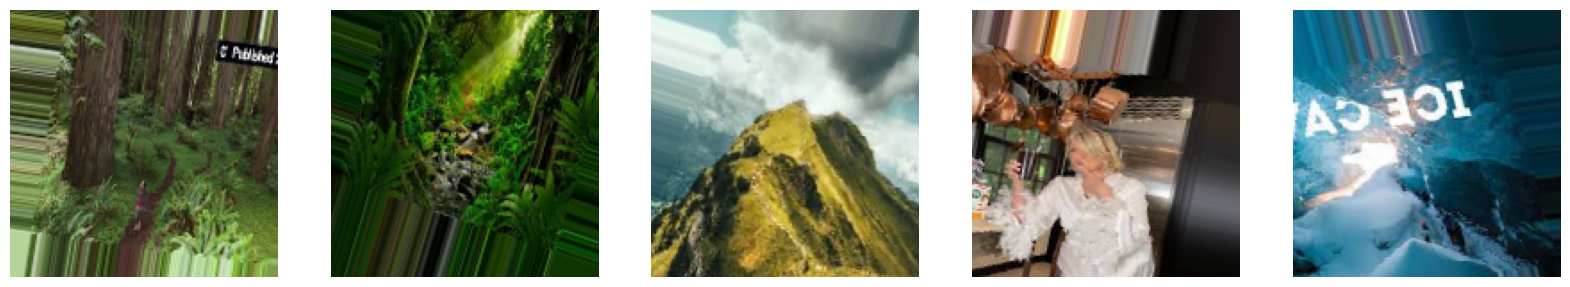

In [4]:
plt.figure(figsize=(20, 6))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    batch = next(train_generator)
    image = batch[0][0]
    plt.imshow(image)
    plt.axis('off')
plt.show()

### Imágenes de *Test*

Para comprobar si la conversión se hizo adecuadamente, se utiliza *plot* para mostrar visualizaciones de algunas de las imágenes.

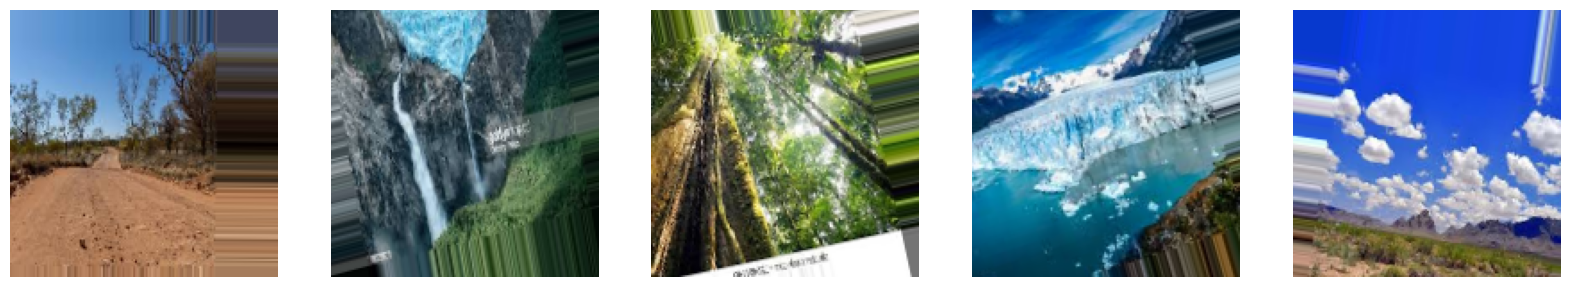

In [5]:
plt.figure(figsize=(20, 6))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    batch = next(test_generator)
    image = batch[0][0]
    plt.imshow(image)
    plt.axis('off')
plt.show()

## Creación del Modelo
Para este modelo se decidió utilizar la arquitectura de ***InceptionV3*** sin incluir la capa del modelo original al querer que entrene en capas personalizadas.

Posterior a especificar que el modelo será secuencial y agregar el modelo base que contiene a ***InceptionV3***, se tiene lo siguiente:

1. Capa de reducción de dimensionalidad global: Se agrega una capa de GlobalAveragePooling2D que reduce la dimensionalidad de las características extraídas de la base InceptionV3 a través de un promedio global.
2. Capa *dense*: Posee 256 neuronas y activación ReLU.
3. Capa de salida: Se agrega una capa densa final con 5 neuronas (correspondientes a las 5 clases de salida) y activación softmax. Esto genera una distribución de probabilidad sobre las clases, indicando la probabilidad de que una imagen pertenezca a cada clase.

La decisión por utilizar ***InceptionV3*** se hizo por su gran capacidad para identificar correctamente los elementos que pertenecen a cada clase.

In [6]:
from tensorflow.keras import optimizers
from tensorflow.keras import models
from tensorflow.keras import layers
from keras.applications.inception_v3 import InceptionV3

layer_names = ['clre1', 'clre2', 'clre3', 'clre4', 'clre5']

base_model = InceptionV3(weights="imagenet", include_top=False, input_shape=(150, 150, 3))
base_model.trainable = False

# En caso de requerir fine tune, cambiar trainable a true
# fine_tune_at = 100

# for layer in base_model.layers[:fine_tune_at]:
#      layer.trainable = False

inputs = layers.Input(shape=(150, 150, 3), name='input')

x = base_model(inputs)

x = layers.Flatten(name=layer_names[1])(x)
x = layers.Dense(512, activation='relu', name=layer_names[2])(x)
x = layers.Dropout(0.5, name=layer_names[3])(x)
outputs = layers.Dense(5, activation='softmax', name=layer_names[4])(x)

model = models.Model(inputs=inputs, outputs=outputs)

model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=1e-5),
              metrics=['acc'])

history = model.fit(
    train_generator,
    epochs=40,
    validation_data=validation_generator
)

acc = history.history['acc']
loss = history.history['loss']


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ inception_v3 (Functional)       │ (None, 3, 3, 2048)     │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ clre2 (Flatten)                 │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ clre3 (Dense)                   │ (None, 512)            │     9,437,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ clre4 (Dropout)                 │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ clre5 (Dense)                   │ (None, 5)              │         2,565 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,243,045 (119.18 MB)

 Trainable params: 9,440,261 (36.01 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

Epoch 1/40


c:\Users\crisb\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


132/132 ━━━━━━━━━━━━━━━━━━━━ 109s 772ms/step - acc: 0.4009 - loss: 1.8355 - val_acc: 0.6113 - val_loss: 1.0508
Epoch 2/40
132/132 ━━━━━━━━━━━━━━━━━━━━ 100s 750ms/step - acc: 0.6324 - loss: 1.0441 - val_acc: 0.6507 - val_loss: 0.9368
Epoch 3/40
132/132 ━━━━━━━━━━━━━━━━━━━━ 104s 778ms/step - acc: 0.6659 - loss: 0.9376 - val_acc: 0.6707 - val_loss: 0.9165
Epoch 4/40
132/132 ━━━━━━━━━━━━━━━━━━━━ 102s 762ms/step - acc: 0.6956 - loss: 0.8710 - val_acc: 0.6707 - val_loss: 0.8812
Epoch 5/40
132/132 ━━━━━━━━━━━━━━━━━━━━ 101s 754ms/step - acc: 0.7035 - loss: 0.8224 - val_acc: 0.6927 - val_loss: 0.8501
Epoch 6/40
132/132 ━━━━━━━━━━━━━━━━━━━━ 114s 855ms/step - acc: 0.7192 - loss: 0.7883 - val_acc: 0.6933 - val_loss: 0.8190
Epoch 7/40
132/132 ━━━━━━━━━━━━━━━━━━━━ 105s 786ms/step - acc: 0.7230 - loss: 0.7730 - val_acc: 0.7027 - val_loss: 0.8346
Epoch 8/40
132/132 ━━━━━━━━━━━━━━━━━━━━ 102s 765ms/step - acc: 0.7350 - loss: 0.7554 - val_acc: 0.6973 - val_loss: 0.8262
Epoch 9/40
132/132 ━━━━━━━━━━━━━━━━

<Figure size 640x480 with 0 Axes>

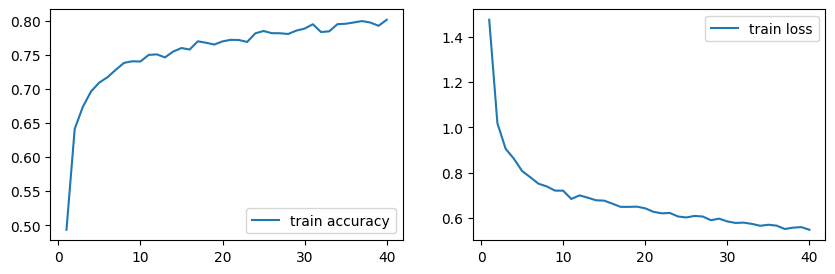

In [7]:
epochs = range(1, len(acc)+1)

plt.figure()
#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(1, 2, figsize=(10, 3))
axarr[0].plot(epochs,acc,label='train accuracy')
axarr[0].legend()
axarr[1].plot(epochs,loss,label='train loss')
axarr[1].legend()

In [8]:
test_loss, test_acc = model.evaluate(test_generator)
print('\ntest acc :\n', test_acc)

predictions = model.predict(test_generator)
predict_class = (predictions > 0.5).astype("int32")
predict_class.shape

33/33 ━━━━━━━━━━━━━━━━━━━━ 26s 779ms/step - acc: 0.7949 - loss: 0.5736

test acc :
 0.7919047474861145
33/33 ━━━━━━━━━━━━━━━━━━━━ 24s 686ms/step


(2100, 5)

### Accuracy: Training / Validation

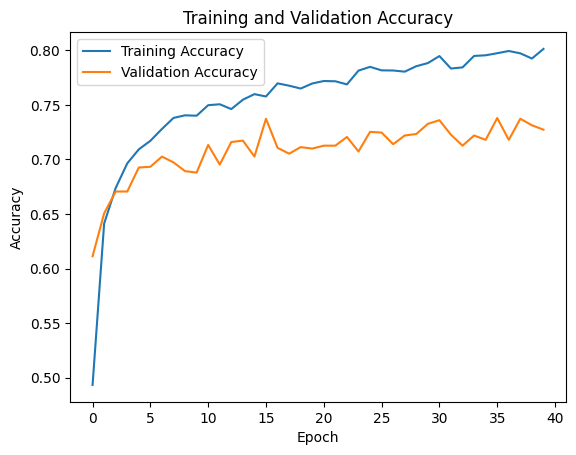

In [9]:
plt.plot(history.history['acc'], label='Training Accuracy')
plt.plot(history.history['val_acc'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Loss: Training / Validation

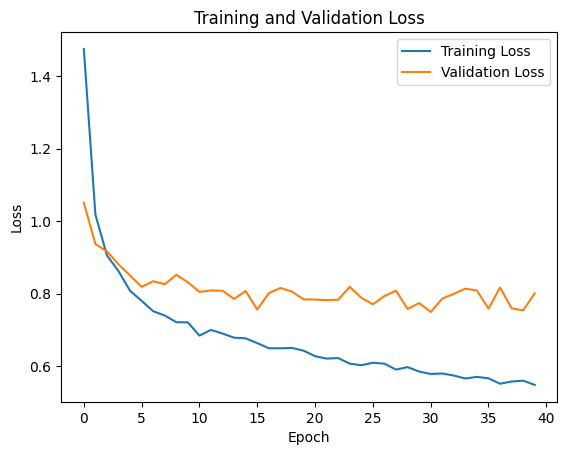

In [10]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Comparación de Resultados

In [11]:
test_imgs = test_generator[0][0]
test_labels = test_generator[0][1]

test_nV = np.argmax(test_labels, axis= 1)


predictions = model.predict(test_imgs)
classes_x = np.argmax(predictions,axis=1)
classes_x

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 256ms/step


array([4, 0, 0, 0, 3, 1, 0, 3, 0, 3, 1, 1, 3, 2, 4, 0, 0, 4, 3, 4, 0, 0,
       0, 3, 3, 2, 4, 0, 1, 4, 4, 4, 1, 2, 4, 4, 4, 2, 3, 0, 0, 4, 1, 0,
       0, 1, 0, 2, 2, 0, 2, 2, 1, 0, 0, 4, 3, 3, 3, 3, 4, 1, 2, 0],
      dtype=int64)

### Matriz de Confusión
Haciendo uso de *seaborn* para generar un mapa de calor, se puede observar que el modelo puede identificar el contenido de una de las clases, usualmente mejor en unas que en otras.

132/132 ━━━━━━━━━━━━━━━━━━━━ 83s 627ms/step


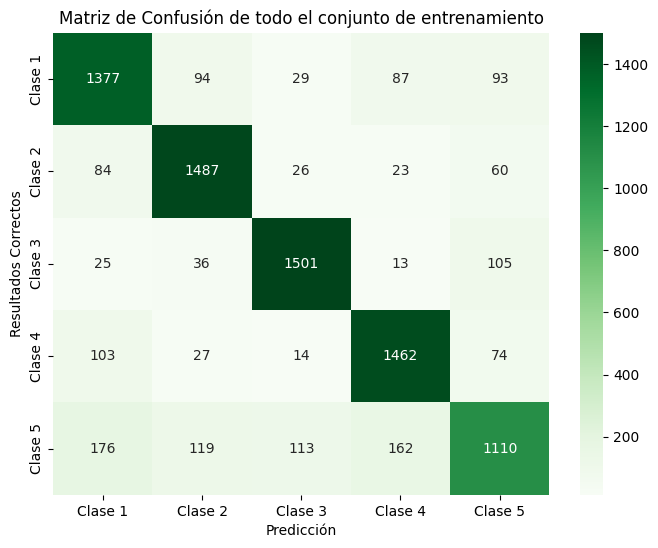

In [12]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Obtener todas las etiquetas reales
all_true_labels = []
for i in range(len(train_generator)):
    batch = train_generator[i]
    true_labels_batch = np.argmax(batch[1], axis=1)
    all_true_labels.extend(true_labels_batch)

# Obtener todas las predicciones
all_predictions = model.predict(train_generator)

# Convertir las etiquetas a índices de clases
predicted_labels = np.argmax(all_predictions, axis=1)

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(all_true_labels, predicted_labels)

# Visualización
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Greens", xticklabels=["Clase 1", "Clase 2", "Clase 3", "Clase 4", "Clase 5"], yticklabels=["Clase 1", "Clase 2", "Clase 3", "Clase 4", "Clase 5"])
plt.xlabel('Predicción')
plt.ylabel('Resultados Correctos')
plt.title('Matriz de Confusión de todo el conjunto de entrenamiento')
plt.show()

## Muestreo de Predicciones

In [13]:
def plot_image(i, predictions_array, true_label, img):
  true_label, img = true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  true_label = true_label[i]
  plt.grid(False)
  plt.xticks(range(5))
  plt.yticks([])
  thisplot = plt.bar(range(5), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

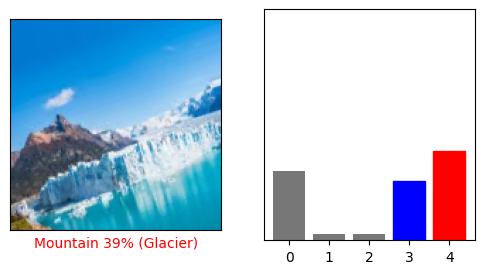

In [14]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], test_nV, test_imgs)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  test_nV)
plt.show()

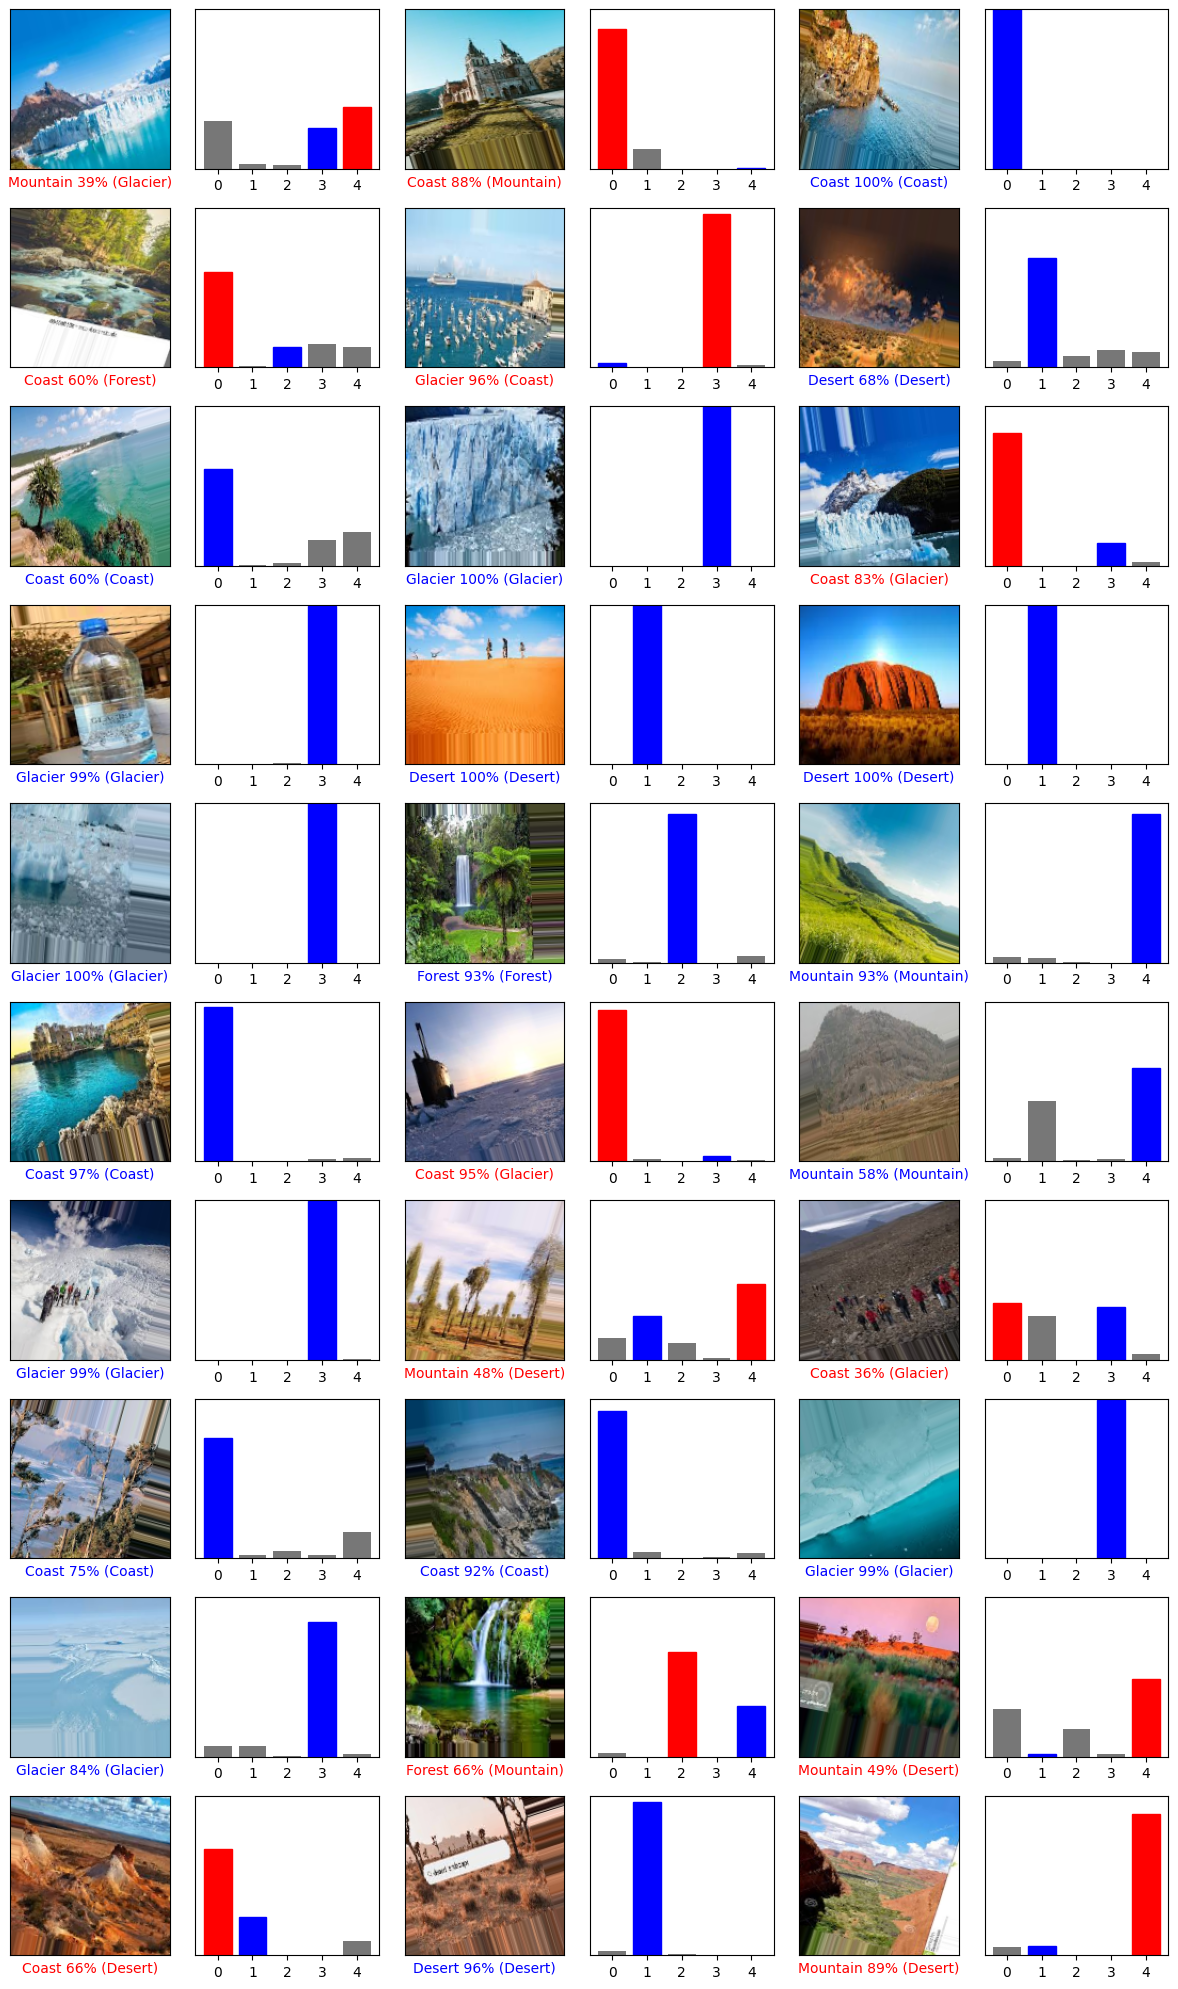

In [15]:
num_rows = 10
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions[i], test_nV, test_imgs)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions[i], test_nV)
plt.tight_layout()
plt.show()

In [16]:
model.save('modelv2_2.keras')